In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np
import os
from keras.applications.inception_v3 import preprocess_input


In [3]:
IMAGE_SIZE = 256
CHANNELS = 3
data_dir = '../data/augmented'
EPOCHS = 45
BATCH_SIZE=32
n_classes = 6

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMAGE_SIZE,IMAGE_SIZE),
  batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMAGE_SIZE,IMAGE_SIZE),
  batch_size=BATCH_SIZE)

Found 15000 files belonging to 6 classes.
Using 12000 files for training.
Found 15000 files belonging to 6 classes.
Using 3000 files for validation.


In [4]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
base_model = tf.keras.applications.InceptionV3(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS),
                                               include_top=False,
                                               weights='imagenet')

In [5]:
for layer in base_model.layers:
    layer.trainable = False

In [6]:
class_names = train_ds.class_names

['Black_or_Red', 'Blue', 'Donation_box', 'Glass', 'Green_or_Brown', 'Yellow']

In [6]:

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [7]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [9]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [10]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 6, 6, 2048)


In [11]:
rescale = tf.keras.layers.Rescaling(1./255)
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [12]:
prediction_layer = tf.keras.layers.Dense(n_classes, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
hidden_dense_layer_1 = tf.keras.layers.Dense(2048, activation='relu')
print(prediction_batch.shape)

(32, 6)


In [14]:
inputs = tf.keras.Input(shape=(IMAGE_SIZE,IMAGE_SIZE,CHANNELS))
x= rescale(inputs)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = hidden_dense_layer_1(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 256, 256, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 256, 256, 3)      0         
 bda)                                                            
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0   

In [15]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
model.summary()

Model: "model"


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 256, 256, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAver

In [16]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                            verbose =1,
                                            mode ='max',
                                            baseline=0.80,
                                            restore_best_weights=True,
                                            patience=8)

In [18]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  callbacks=[callbacks],
  epochs=EPOCHS
)

Epoch 1/45
375/375 [==============================] - 81s 214ms/step - loss: 0.0923 - accuracy: 0.9668 - val_loss: 0.3741 - val_accuracy: 0.9097
Epoch 2/45
375/375 [==============================] - 80s 214ms/step - loss: 0.0880 - accuracy: 0.9689 - val_loss: 0.3728 - val_accuracy: 0.9173
Epoch 3/45
375/375 [==============================] - 81s 216ms/step - loss: 0.0892 - accuracy: 0.9682 - val_loss: 0.3518 - val_accuracy: 0.9207
Epoch 4/45
375/375 [==============================] - 82s 219ms/step - loss: 0.0823 - accuracy: 0.9707 - val_loss: 0.3795 - val_accuracy: 0.9133
Epoch 5/45
375/375 [==============================] - 81s 215ms/step - loss: 0.0688 - accuracy: 0.9750 - val_loss: 0.3719 - val_accuracy: 0.9207
Epoch 6/45
375/375 [==============================] - 81s 215ms/step - loss: 0.0822 - accuracy: 0.9713 - val_loss: 0.3377 - val_accuracy: 0.9163
Epoch 7/45
375/375 [==============================] - 81s 215ms/step - loss: 0.0797 - accuracy: 0.9719 - val_loss: 0.3568 - val_ac

In [19]:
prediction = model.predict(val_ds)

94/94 [==============================] - 10s 93ms/step


In [20]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 31ms/step


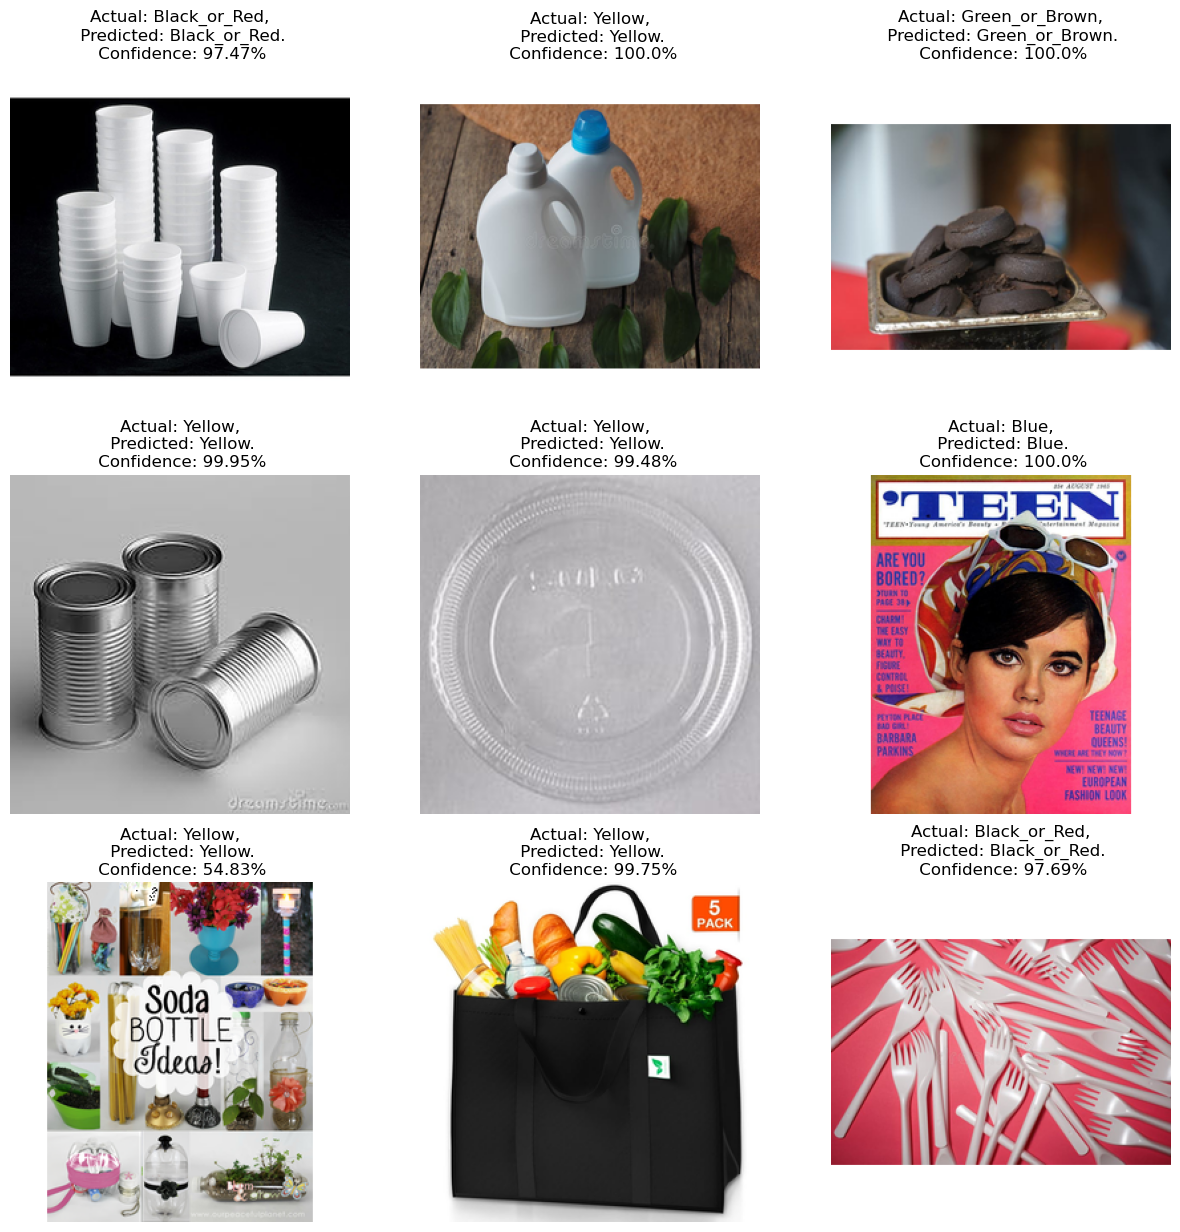

In [30]:
plt.figure(figsize=(15, 15))
for images, labels in val_ds:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[labels[i].numpy()] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
    break

In [32]:
model_version = max([int(i) for i in os.listdir("../models")+[0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/4\assets


INFO:tensorflow:Assets written to: ../models/4\assets


In [33]:
model.save("../models/garbage_InceptionV3.h5")